In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------- Utilities --------------------

def resample_to_5min(solar_15min: np.ndarray) -> np.ndarray:
    """Linearly interpolate a 15-min series to 5-min resolution (3x points)."""
    solar_15min = np.asarray(solar_15min, dtype=float)
    n15 = solar_15min.size
    if n15 < 2:
        raise ValueError("solar_15min must have at least 2 points")
    x_old = np.arange(n15)
    x_new = np.linspace(0, n15 - 1, n15 * 3)  # 3 steps per 15-min
    return np.interp(x_new, x_old, solar_15min)


def maximal_ramped_with_bounds(
    U: np.ndarray,                    # per-step upper bound on hydro
    ramp_up_step: float,              # MW per step
    ramp_dn_step: float,              # MW per step
    L: np.ndarray | None = None,      # per-step lower bound (>=0). If None -> zeros.
    initial_hydro_mw: float | None = None
):
    """
    Find the maximum hydro schedule h subject to:
        L[t] <= h[t] <= U[t]
        h[t] - h[t-1] <= ramp_up_step
        h[t-1] - h[t] <= ramp_dn_step
    Returns (feasible: bool, h: np.ndarray | None).
    """
    U = np.asarray(U, dtype=float)
    n = U.size
    if L is None:
        L = np.zeros(n, dtype=float)
    else:
        L = np.asarray(L, dtype=float)

    # Infeasible if any L > U to start
    if np.any(L - U > 1e-12):
        return False, None

    # Start from the top within [L, U]
    h = np.minimum(U, np.maximum(L, U)).copy()

    # Apply initial constraints if provided
    if initial_hydro_mw is not None:
        lb0 = max(L[0], initial_hydro_mw - ramp_dn_step)
        ub0 = min(U[0], initial_hydro_mw + ramp_up_step)
        if lb0 > ub0 + 1e-12:
            return False, None
        h[0] = min(h[0], ub0)
        if h[0] < lb0:
            h[0] = lb0

    # Iteratively enforce ramp-up/down while respecting [L, U]
    changed = True
    iters, max_iters = 0, 20
    while changed and iters < max_iters:
        changed = False
        iters += 1

        # Forward pass: limit by ramp-up from previous and lower bound from ramp-down
        for t in range(1, n):
            max_allowed = h[t-1] + ramp_up_step
            min_allowed = h[t-1] - ramp_dn_step
            new_ht = h[t]
            if new_ht > max_allowed:
                new_ht = max_allowed
            if new_ht < max(L[t], min_allowed):
                new_ht = max(L[t], min_allowed)
            if new_ht > U[t]:
                new_ht = U[t]
            if abs(new_ht - h[t]) > 1e-12:
                h[t] = new_ht
                changed = True

        # Backward pass: limit by ramp-down to next and lower bound from ramp-up
        for t in range(n - 2, -1, -1):
            max_allowed = h[t+1] + ramp_dn_step
            min_allowed = h[t+1] - ramp_up_step
            new_ht = h[t]
            if new_ht > max_allowed:
                new_ht = max_allowed
            if new_ht < max(L[t], min_allowed):
                new_ht = max(L[t], min_allowed)
            if new_ht > U[t]:
                new_ht = U[t]
            if abs(new_ht - h[t]) > 1e-12:
                h[t] = new_ht
                changed = True

        # Re-check bounds
        if np.any(h < L - 1e-9) or np.any(h > U + 1e-9):
            return False, None

    # Final sanity on ramps
    dh = np.diff(h)
    if np.any(dh > ramp_up_step + 1e-9) or np.any(-dh > ramp_dn_step + 1e-9):
        return False, None

    return True, h


# -------------------- Main driver (no curtailment, max LF) --------------------

def compute_hydro_max_LF_no_curtailment(
    solar_15min_mw: np.ndarray,
    hydro_max_mw: float,
    hydro_energy_mwh_total: float,         # daily usable energy (budget for the window)
    ramp_up_mw_per_min: float,
    ramp_dn_mw_per_min: float | None = None,
    initial_hydro_mw: float | None = None,
    dt_control_min: int = 5
):
    """
    Maximizes LF without curtailment by valley filling:
      - Prefer not to raise the natural solar peak.
      - If initial+ramp makes that infeasible, raise peak minimally.
      - Respect hydro max power, ramp limits, and daily energy budget.
    Returns dict with schedule and metrics at control (5-min) resolution.
    """
    if ramp_dn_mw_per_min is None:
        ramp_dn_mw_per_min = ramp_up_mw_per_min

    # Resample solar to control step
    if dt_control_min == 5:
        solar = resample_to_5min(np.asarray(solar_15min_mw, dtype=float))
    else:
        solar = np.asarray(solar_15min_mw, dtype=float)

    n = solar.size
    dt_h = dt_control_min / 60.0
    s_max = float(np.max(solar))

    # Ramp in MW/step
    ru_step = ramp_up_mw_per_min * dt_control_min
    rd_step = ramp_dn_mw_per_min * dt_control_min

    # Lower bound from initial (if any) due to ramp-down limitation
    if initial_hydro_mw is not None:
        L = np.zeros(n)
        L[0] = max(0.0, initial_hydro_mw - rd_step)
        for t in range(1, n):
            L[t] = max(0.0, L[t-1] - rd_step)
    else:
        L = np.zeros(n)

    # Outer loop: minimally raise the effective peak C if required by ramp/initial feasibility
    C_lo = s_max
    C_hi = float(np.min(solar + hydro_max_mw))  # absolute upper bound if hydro at max everywhere
    C = C_lo

    def build_max_schedule_for_cap(C_try, alpha=1.0):
        # Upper bound on hydro to avoid exceeding delivered cap C_try:
        # h(t) <= min(hydro_max_mw, max(0, C_try - solar(t))) scaled by alpha (for energy control)
        Ucap = np.maximum(0.0, C_try - solar)
        Ucap = np.minimum(hydro_max_mw, Ucap) * alpha
        feasible, h = maximal_ramped_with_bounds(Ucap, ru_step, rd_step, L=L, initial_hydro_mw=initial_hydro_mw)
        return feasible, h

    # Find minimal C that yields feasibility (with alpha=1)
    feasible, h = build_max_schedule_for_cap(C, alpha=1.0)
    if not feasible:
        # Increase C until feasible or we hit C_hi
        for _ in range(60):
            mid = 0.5 * (C + C_hi)
            feas_mid, _h = build_max_schedule_for_cap(mid, alpha=1.0)
            if feas_mid:
                C_hi = mid
                h = _h
            else:
                C = mid
            if C_hi - C <= 1e-4:
                break
        # Use the feasible schedule at minimal C_hi
        C = C_hi
        feasible, h = build_max_schedule_for_cap(C, alpha=1.0)
        if not feasible:
            return {"feasible": False, "message": "Could not find a feasible schedule even after raising peak."}

    # Now enforce the energy budget by scaling the per-step cap with alpha ∈ [0, 1]
    # This keeps peak at C (no curtailment) and preserves ramps.
    def energy_for_alpha(alpha):
        feas, h_tmp = build_max_schedule_for_cap(C, alpha)
        if not feas:
            return None, None
        return (h_tmp.sum() * dt_h), h_tmp

    if np.isinf(hydro_energy_mwh_total):
        used_energy, h = energy_for_alpha(1.0)
    else:
        e_full, h_full = energy_for_alpha(1.0)
        if e_full is None:
            return {"feasible": False, "message": "Feasibility failure during energy sizing."}
        if e_full <= hydro_energy_mwh_total + 1e-9:
            used_energy, h = e_full, h_full
        else:
            # Bisection on alpha to meet the budget
            lo, hi = 0.0, 1.0
            best_h, best_e = np.zeros_like(solar), 0.0
            for _ in range(60):
                mid = 0.5 * (lo + hi)
                e_mid, h_mid = energy_for_alpha(mid)
                if e_mid is None:
                    hi = mid
                    continue
                if e_mid <= hydro_energy_mwh_total:
                    lo = mid
                    best_h, best_e = h_mid, e_mid
                else:
                    hi = mid
                if hi - lo <= 1e-4:
                    break
            h = best_h
            used_energy = best_e

    delivered = solar + h  # no curtailment
    peak = float(np.max(delivered))
    avg = float(np.mean(delivered))
    load_factor = (avg / peak) if peak > 0 else np.nan

    return {
        "feasible": True,
        "firm_cap_mw": float(C),                # effective cap we stayed under (≥ solar peak if needed)
        "hydro_mw": h,
        "delivered_mw": delivered,
        "solar_mw": solar,
        "used_hydro_energy_mwh": float(used_energy),
        "hydro_energy_budget_mwh": float(hydro_energy_mwh_total),
        "hydro_max_mw": float(hydro_max_mw),
        "ramp_up_mw_per_min": float(ramp_up_mw_per_min),
        "ramp_dn_mw_per_min": float(ramp_dn_mw_per_min),
        "initial_hydro_mw": None if initial_hydro_mw is None else float(initial_hydro_mw),
        "dt_control_min": int(dt_control_min),
        "load_factor": float(load_factor),
        "peak_mw": peak,
        "avg_mw": avg
    }



Effective cap C (MW): 79.851  (≥ solar peak only if needed)
Hydro energy used (MWh): 240.00 / 240.00
Hydro max (MW): 50.0
Ramp up/down (MW/min): 4.0/4.0
Load Factor: 0.631501 | Peak (MW): 79.85 | Avg (MW): 50.43


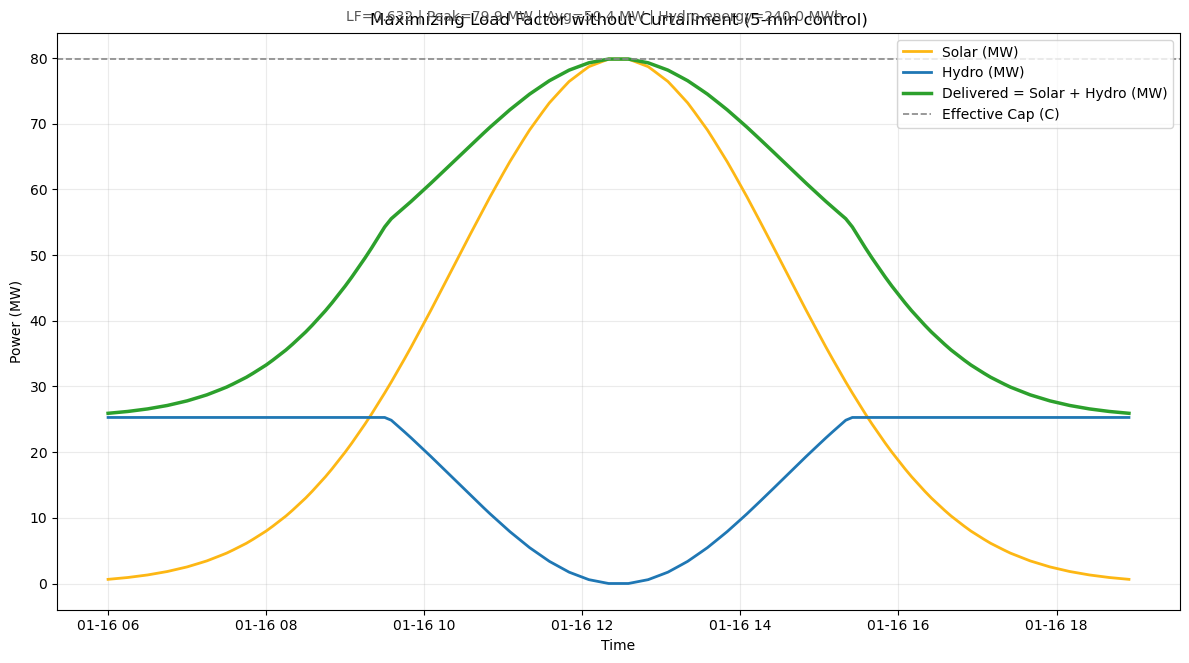

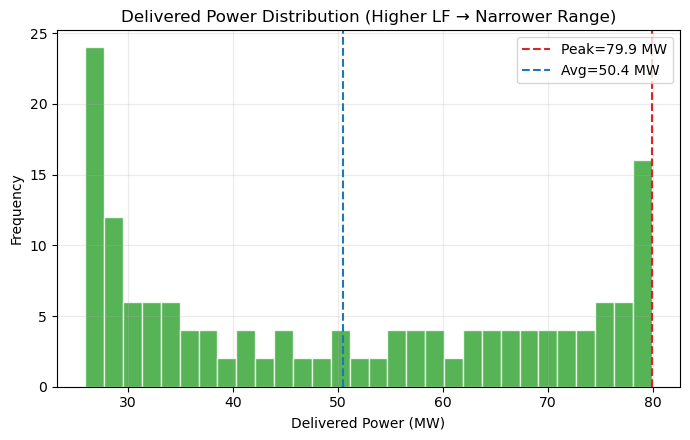

In [4]:

# -------------------- Example & Plot --------------------

if __name__ == "__main__":
    # Example solar profile: 06:00–19:00, 15-min points (inclusive-left)
    start = pd.Timestamp("2026-01-16 06:00")
    end = pd.Timestamp("2026-01-16 19:00")
    idx_15 = pd.date_range(start, end, freq="15min", inclusive="left")
    n15 = len(idx_15)

    # Synthetic bell-shaped solar (MW) peaking near noon (~80 MW)
    x = np.linspace(-2.2, 2.2, n15)
    solar_15 = 80 * np.exp(-x**2)

    # Hydro constraints
    hydro_max_mw = 50.0
    hydro_energy_mwh_total = 240.0   # daily usable energy for this window
    ramp_up_mw_per_min = 4.0
    ramp_dn_mw_per_min = 4.0
    initial_hydro_mw = None          # or set e.g. 20.0 to test initial/ramp feasibility

    # Run optimizer at 5-min control step
    result = compute_hydro_max_LF_no_curtailment(
        solar_15min_mw=solar_15,
        hydro_max_mw=hydro_max_mw,
        hydro_energy_mwh_total=hydro_energy_mwh_total,
        ramp_up_mw_per_min=ramp_up_mw_per_min,
        ramp_dn_mw_per_min=ramp_dn_mw_per_min,
        initial_hydro_mw=initial_hydro_mw,
        dt_control_min=5
    )

    if not result.get("feasible", False):
        print("Infeasible:", result.get("message", ""))
    else:
        # Build a 5-min index and unpack
        idx_5 = pd.date_range(start, end, freq="5min", inclusive="left")
        solar_5 = result["solar_mw"]
        hydro = result["hydro_mw"]
        delivered = result["delivered_mw"]
        C_eff = result["firm_cap_mw"]

        print(f"Effective cap C (MW): {C_eff:.3f}  (≥ solar peak only if needed)")
        print(f"Hydro energy used (MWh): {result['used_hydro_energy_mwh']:.2f} / {result['hydro_energy_budget_mwh']:.2f}")
        print(f"Hydro max (MW): {result['hydro_max_mw']:.1f}")
        print(f"Ramp up/down (MW/min): {result['ramp_up_mw_per_min']:.1f}/{result['ramp_dn_mw_per_min']:.1f}")
        print(f"Load Factor: {result['load_factor']:.6f} | Peak (MW): {result['peak_mw']:.2f} | Avg (MW): {result['avg_mw']:.2f}")

        # ---------- Plot 1: time series ----------
        plt.figure(figsize=(12, 7))
        plt.plot(idx_5, solar_5, label="Solar (MW)", color="#FDB714", linewidth=2.0)
        plt.plot(idx_5, hydro, label="Hydro (MW)", color="#1F77B4", linewidth=2.0)
        plt.plot(idx_5, delivered, label="Delivered = Solar + Hydro (MW)", color="#2CA02C", linewidth=2.5)
        plt.axhline(C_eff, color="#888", linestyle="--", linewidth=1.2, label="Effective Cap (C)")

        plt.title("Maximizing Load Factor without Curtailment (5-min control)")
        plt.xlabel("Time")
        plt.ylabel("Power (MW)")
        plt.grid(True, alpha=0.25)
        plt.legend(loc="upper right")
        subtitle = (f"LF={result['load_factor']:.3f} | Peak={result['peak_mw']:.1f} MW | "
                    f"Avg={result['avg_mw']:.1f} MW | Hydro energy={result['used_hydro_energy_mwh']:.1f} MWh")
        plt.suptitle(subtitle, y=0.94, fontsize=10, color="#555")
        plt.tight_layout()
        plt.show()

        # ---------- Plot 2: histogram of delivered (shape flatness) ----------
        plt.figure(figsize=(7, 4.5))
        plt.hist(delivered, bins=30, color="#2CA02C", alpha=0.8, edgecolor="white")
        plt.axvline(np.max(delivered), color="#D62728", linestyle="--", label=f"Peak={np.max(delivered):.1f} MW")
        plt.axvline(np.mean(delivered), color="#1F77B4", linestyle="--", label=f"Avg={np.mean(delivered):.1f} MW")
        plt.title("Delivered Power Distribution (Higher LF → Narrower Range)")
        plt.xlabel("Delivered Power (MW)")
        plt.ylabel("Frequency")
        plt.grid(True, alpha=0.25)
        plt.legend()
        plt.tight_layout()
        plt.show()
